In [63]:
import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [42]:
trainList = os.listdir("../DataTest/")

In [78]:
def parse_info(nom : str)->dict:
    info = {}
    l = nom.split('-')
    coordAnglesPlaque = []
    for coord in l[3].split('_'):
        coord = coord.split("&")
        coordAnglesPlaque.append([int(coo) for coo in coord])
    info['cooAngle']= np.array(coordAnglesPlaque)


    info['carac'] = [int(char) for char in l[4].split('_')[2:]]
    return nom,info

In [79]:
def parseNameList(nameList : list[str]) -> dict:
    infoGlobal = {}
    for name in nameList :
        nom, info = parse_info(name)
        infoGlobal[nom] = info
    return infoGlobal

In [80]:
dic = parseNameList(trainList)

print(parseNameList(trainList))

{'047974137931-92_80-44&405_446&537-447&539_68&518_49&407_428&428-0_0_5_25_32_25_5-62-307.jpg': {'cooAngle': array([[447, 539],
       [ 68, 518],
       [ 49, 407],
       [428, 428]]), 'carac': [5, 25, 32, 25, 5]}, '06061302682-90_86-118&467_595&595-598&599_143&599_135&474_590&474-0_0_12_25_32_32_32-93-299.jpg': {'cooAngle': array([[598, 599],
       [143, 599],
       [135, 474],
       [590, 474]]), 'carac': [12, 25, 32, 32, 32]}, '063436302682-90_81-138&450_592&605-606&602_154&584_115&449_567&467-0_0_9_29_22_31_32-49-298.jpg': {'cooAngle': array([[606, 602],
       [154, 584],
       [115, 449],
       [567, 467]]), 'carac': [9, 29, 22, 31, 32]}}


In [136]:
def computeHomographie(nom : str, dic : dict) -> np.ndarray:
    im = cv.cvtColor(cv.imread(f"../DataTest/{nom}"),cv.COLOR_BGR2GRAY)
    h, status = cv.findHomography(dic[nom]['cooAngle'],np.array([[110,35],[0,35],[0,0],[110,0]]))
    im_dst = cv.warpPerspective(im,h,(111,36))
    return im_dst

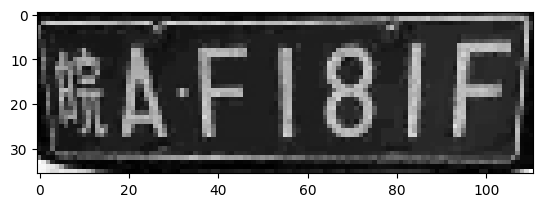

In [170]:
img = computeHomographie('047974137931-92_80-44&405_446&537-447&539_68&518_49&407_428&428-0_0_5_25_32_25_5-62-307.jpg',dic)

plt.imshow(img,cmap='gray')

In [160]:
def binarize(img : np.ndarray):
    imgFinal = []

    seuil = 120
    minLigne = 5
    maxLigne = 27
    minCol = 35
    maxCol = 105

    for num,ligne in enumerate(img):
        lign = [0 if (i < seuil or num < minLigne or num > maxLigne or col < minCol or col > maxCol) else 1 for col,i in enumerate(ligne)]
        imgFinal.append(lign)
    imgFinal = np.array(imgFinal)
    plt.imshow(imgFinal,cmap='gray')
    return imgFinal

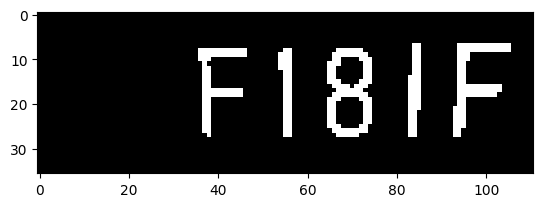

In [174]:
imgFinal = binarize(img)

In [175]:
hist = [0] *111
for ligne in imgFinal :
    for index,val in enumerate(ligne):
        hist[index] = hist[index] + val

In [179]:
def lookForColumnLetter(hist):
    IOList = []
    isLetter = False
    startLetter = 0
    for index, val in enumerate(hist):
        if isLetter:
            if val == 0:
                isLetter = False
                IOList.append((startLetter,index))
        else:
            if val != 0:
                isLetter = True
                startLetter = index
    return IOList

In [207]:
def lookForLetter(IOList,imgFinal):
    infoLetter = [] #point de départ et hauteur et largeur
    hist = [0] * 36
    for min,max in IOList:
        hist = [0] * 36
        for numLigne,ligne in enumerate(imgFinal):
            for colone in range(min,max+1):
                hist[numLigne] = hist[numLigne] + ligne[colone]

        #plt.plot(hist)

        isLetter = False
        startLetter = 0
        for index, val in enumerate(hist):
            if isLetter:
                if val == 0:
                    isLetter = False
                    infoLetter.append(((min,startLetter),(index-startLetter,max-min))) #(xdep, ydep),(hauteur,largeur)
            else:
                if val != 0:
                    isLetter = True
                    startLetter = index
    return infoLetter

In [182]:
ioList = lookForColumnLetter(hist)

print(ioList)

[(36, 47), (54, 57), (65, 75), (83, 86), (93, 106)]


In [208]:
lookForLetter(ioList,imgFinal)

[((36, 8), (20, 11)),
 ((54, 8), (20, 3)),
 ((65, 8), (20, 10)),
 ((83, 7), (21, 3)),
 ((93, 7), (21, 13))]

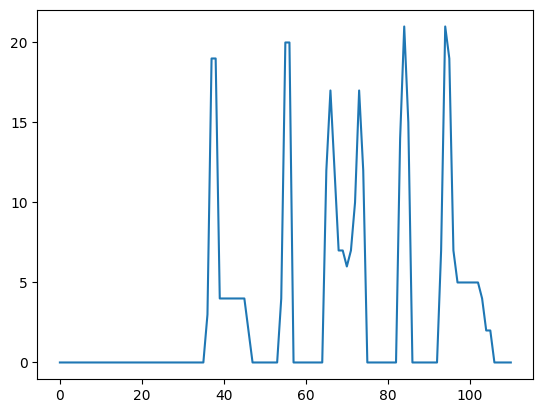

In [176]:
plt.plot(hist)

TODO :

sauvegarder les info de la position des boxs autours des lettres